# Imports

In [15]:
import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

# Loading the data

In [12]:
path = './VOCdevkit/VOC2007/JPEGImages/'
SEED = 42

In [3]:
X = []
y_mid = []
y_large = []

num_images = 100

filelist = glob.glob(path + '*.jpg')
filelist[:10]

for f in filelist[:num_images]:
    img = cv2.imread(f)/255.
    X.append(cv2.resize(img, (72,72)))
    y_mid.append(cv2.resize(img, (144,144)))
    y_large.append(cv2.resize(img, (288,288)))
    
X = np.array(X); y_mid = np.array(y_mid); y_large = np.array(y_large)
X.shape, y_mid.shape, y_large.shape

((100, 72, 72, 3), (100, 144, 144, 3), (100, 288, 288, 3))

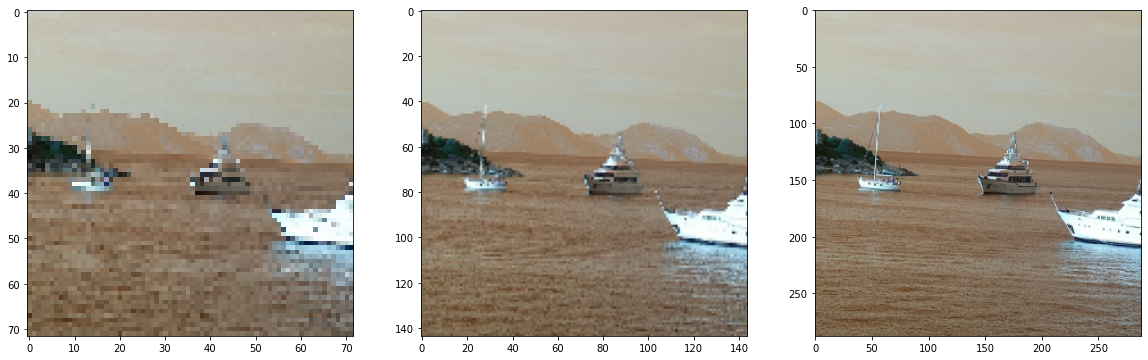

In [4]:
def plot_multiple_images(ind, X, y_mid, y_large):
    fig, ax = plt.subplots(1,3, figsize=(20,6))
    ax[0].imshow(X[ind])
    ax[1].imshow(y_mid[ind])
    ax[2].imshow(y_large[ind])
    
plot_multiple_images(10, X, y_mid, y_large)

# Step 2: creating an initial model

In [33]:
def get_simple_conv_model(input_shape):
    
    inp = Input(shape=input_shape)
    X = Conv2D(64,3, activation='relu', padding='same')(inp)
    X = Conv2D(64,3, activation='relu', padding='same')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out = Conv2D(3,1, activation='sigmoid')(X)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [34]:
model = get_simple_conv_model(input_shape=(X.shape[1:]))
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)        1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 144, 144, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 144, 144, 3)       195       
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0
_________________________________________________________________


In [35]:
split = num_images//5*4
model.fit(X[:split], 
          y_mid[:split], 
          validation_data=(X[split:], y_mid[split:]), 
          epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 386ms/step - loss: 0.0725 - val_loss: 0.0649
Epoch 2/100
3/3 [==============================] - 1s 360ms/step - loss: 0.0680 - val_loss: 0.0619
Epoch 3/100
3/3 [==============================] - 1s 368ms/step - loss: 0.0653 - val_loss: 0.0587
Epoch 4/100
3/3 [==============================] - 1s 368ms/step - loss: 0.0618 - val_loss: 0.0550
Epoch 5/100
3/3 [==============================] - 1s 379ms/step - loss: 0.0574 - val_loss: 0.0497
Epoch 6/100
3/3 [==============================] - 1s 376ms/step - loss: 0.0524 - val_loss: 0.0443
Epoch 7/100
3/3 [==============================] - 1s 369ms/step - loss: 0.0471 - val_loss: 0.0389
Epoch 8/100
3/3 [==============================] - 1s 370ms/step - loss: 0.0411 - val_loss: 0.0335
Epoch 9/100
3/3 [==============================] - 1s 368ms/step - loss: 0.0352 - val_loss: 0.0281
Epoch 10/100
3/3 [==============================] - 1s 370ms/step - loss: 0.0293 - val_loss: 0.0230
Epoch 11/

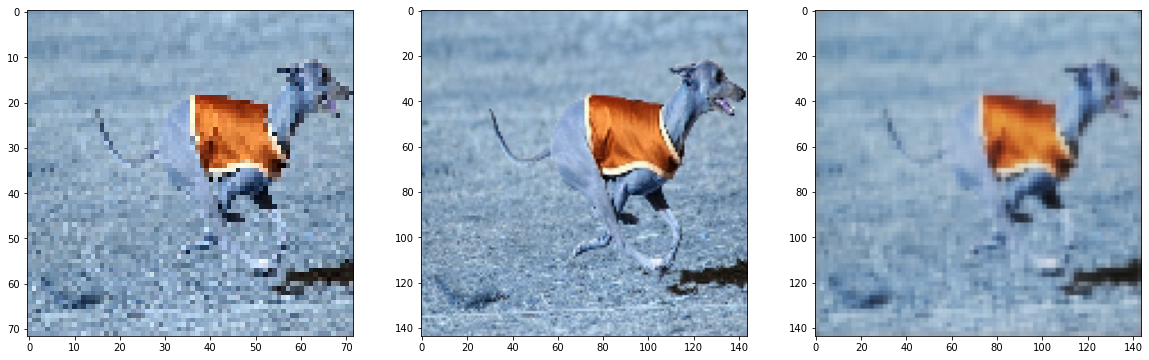

In [36]:
pred = model.predict(X[split:])
plot_multiple_images(2, X[split:], y_mid[split:], pred)

# Step 3: adding another output block

In [39]:
def get_2out_conv_model(input_shape):
    
    inp = Input(shape=input_shape)
    X = Conv2D(64,3, activation='relu', padding='same')(inp)
    X = Conv2D(64,3, activation='relu', padding='same')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out1 = Conv2D(3,1, activation='sigmoid')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out2 = Conv2D(3,1, activation='sigmoid')(X)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse')
    return model

In [40]:
model = get_2out_conv_model(input_shape=(X.shape[1:]))
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 72, 72, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 72, 72, 64)   36928       conv2d_22[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_8 (UpSampling2D)  (None, 144, 144, 64) 0           conv2d_23[0][0]                  
____________________________________________________________________________________________

In [41]:
split = num_images//5*4
model.fit(X[:split], 
          [y_mid[:split],y_large[:split]], 
          validation_data=(X[split:], [y_mid[split:],y_large[split:]]), 
          epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 828ms/step - loss: 0.1520 - conv2d_24_loss: 0.0731 - conv2d_25_loss: 0.0789 - val_loss: 0.1355 - val_conv2d_24_loss: 0.0672 - val_conv2d_25_loss: 0.0683
Epoch 2/100
3/3 [==============================] - 2s 796ms/step - loss: 0.1407 - conv2d_24_loss: 0.0701 - conv2d_25_loss: 0.0706 - val_loss: 0.1293 - val_conv2d_24_loss: 0.0649 - val_conv2d_25_loss: 0.0645
Epoch 3/100
3/3 [==============================] - 2s 800ms/step - loss: 0.1360 - conv2d_24_loss: 0.0680 - conv2d_25_loss: 0.0680 - val_loss: 0.1247 - val_conv2d_24_loss: 0.0623 - val_conv2d_25_loss: 0.0624
Epoch 4/100
3/3 [==============================] - 2s 802ms/step - loss: 0.1311 - conv2d_24_loss: 0.0654 - conv2d_25_loss: 0.0657 - val_loss: 0.1185 - val_conv2d_24_loss: 0.0590 - val_conv2d_25_loss: 0.0595
Epoch 5/100
3/3 [==============================] - 2s 793ms/step - loss: 0.1241 - conv2d_24_loss: 0.0620 - conv2d_25_loss: 0.0621 - val_loss: 0.1107 - val_conv2d_24_loss: 0

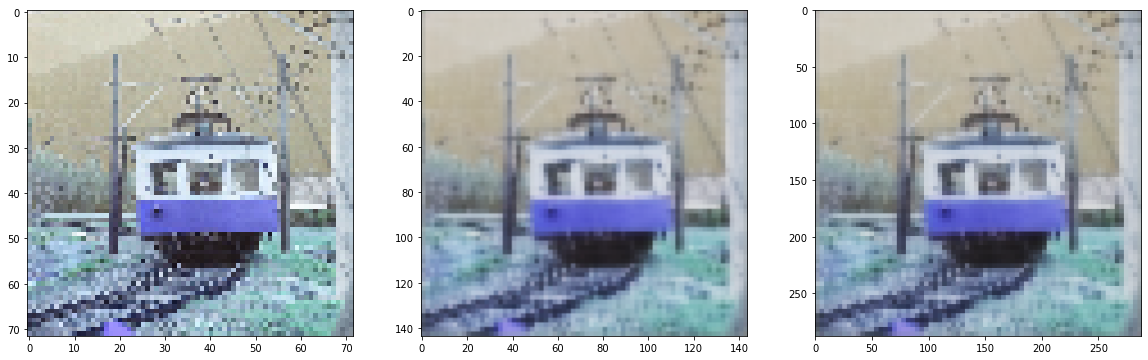

In [51]:
pred = model.predict(X[split:])
pred_y_mid = pred[0]
pred_y_large = pred[1]
plot_multiple_images(10, X[split:], pred_y_mid, pred_y_large)

# Step 4: adding another output block

In [80]:
def get_res_conv_model(input_shape):
    
    def ResBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(X)
        X = Add()([inp, X])
        out = LeakyReLU(alpha=0.2)(X)
        return Model(inp,out)
    
    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out1 = Conv2D(3,3, padding='same')(X)
    out1 = Activation(LeakyReLU(alpha=0.2))(out1)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('sigmoid')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse')
    return model

In [81]:
model = get_res_conv_model(input_shape=(X.shape[1:]))
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, None, None, 3 128         input_35[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, None, None, 3 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
model_14 (Model)                (None, None, None, 3 18496       activation_4[0][0]               
___________________________________________________________________________________________

In [ ]:
split = num_images//5*4
model.fit(X[:split], 
          [y_mid[:split],y_large[:split]], 
          validation_data=(X[split:], [y_mid[split:],y_large[split:]]), 
          epochs=50)

In [ ]:
pred = model.predict(X[split:])
pred_y_mid = pred[0]
pred_y_large = pred[1]
plot_multiple_images(10, X[split:], pred_y_mid, pred_y_large)

# Step 5: dilated (Atrous) convolutional blocks

In [97]:
def get_dilated_conv_model(input_shape):
    
    def DilatedBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        d1 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        d2 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        d4 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        x = Concatenate()([d1,d2,d4])
        x = LeakyReLU(alpha=0.2)(x)
        out = Conv2D(32,3, activation='relu', padding='same')(x)
        return Model(inp,out)
    
    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = DilatedBlock(32)(X)
    X = DilatedBlock(32)(X)
    X = UpSampling2D()(X)
    out1 = Conv2D(3,1, padding='same')(X)
    out1 = Activation('relu')(out1)
    X = DilatedBlock(32)(X)
    X = UpSampling2D()(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('relu')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse')
    return model

In [98]:
model = get_dilated_conv_model(input_shape=(X.shape[1:]))
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, None, None, 3 128         input_54[0][0]                   
__________________________________________________________________________________________________
activation_13 (Activation)      (None, None, None, 3 0           conv2d_108[0][0]                 
__________________________________________________________________________________________________
model_28 (Model)                (None, None, None, 3 55424       activation_13[0][0]              
___________________________________________________________________________________________

In [ ]:
split = num_images//5*4
model.fit(X[:split], 
          [y_mid[:split],y_large[:split]], 
          validation_data=(X[split:], [y_mid[split:],y_large[split:]]), 
          epochs=30)

Epoch 1/30
3/3 [==============================] - 9s 3s/step - loss: 0.4633 - activation_14_loss: 0.1979 - activation_15_loss: 0.2654 - val_loss: 0.2315 - val_activation_14_loss: 0.1226 - val_activation_15_loss: 0.1089
Epoch 2/30
3/3 [==============================] - 9s 3s/step - loss: 0.2439 - activation_14_loss: 0.1248 - activation_15_loss: 0.1191 - val_loss: 0.3268 - val_activation_14_loss: 0.1603 - val_activation_15_loss: 0.1665
Epoch 3/30
3/3 [==============================] - 9s 3s/step - loss: 0.3049 - activation_14_loss: 0.1562 - activation_15_loss: 0.1486 - val_loss: 0.2575 - val_activation_14_loss: 0.1476 - val_activation_15_loss: 0.1098
Epoch 4/30
3/3 [==============================] - 9s 3s/step - loss: 0.2309 - activation_14_loss: 0.1346 - activation_15_loss: 0.0963 - val_loss: 0.1880 - val_activation_14_loss: 0.1223 - val_activation_15_loss: 0.0657
Epoch 5/30
3/3 [==============================] - 9s 3s/step - loss: 0.1630 - activation_14_loss: 0.1180 - activation_15_los

In [ ]:
pred = model.predict(X[split:])
pred_y_mid = pred[0]
pred_y_large = pred[1]
plot_multiplev_images(10, X[split:], pred_y_mid, pred_y_large)

# Step 6: adding a pretrained network as a feature extractor

# Step 7: us